# Pre-processing and Modeling

Due to some issues with tensor flow and the need for additional resources, I ran this notebook in google colab. 

In [1]:
pip install imagehash

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.7/296.7 kB 19.0 MB/s eta 0:00:00


In [2]:
!pip uninstall -y typeguard inflect tensorflow-addons
!pip install typeguard==2.13.3 tensorflow-addons==0.23.0

Found existing installation: typeguard 4.4.2
Uninstalling typeguard-4.4.2:
  Successfully uninstalled typeguard-4.4.2
Found existing installation: inflect 7.5.0
Uninstalling inflect-7.5.0:
  Successfully uninstalled inflect-7.5.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 41.5 MB/s eta 0:00:00


In [3]:
pip install tensorflow-addons --no-deps

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import libraries 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import imagehash
import hashlib
from collections import defaultdict
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2, EfficientNetB0
from tensorflow.keras.applications import efficientnet, mobilenet_v2
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, Input
from sklearn.utils import class_weight
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'  # 0 = all logs, 1 = filter INFO, 2 = filter WARNING, 3 = filter ERROR

### Load Dataframe and Split Data

The first step was to load and split the data.

In [6]:
df = pd.read_csv('/content/drive/MyDrive/Springboard_Data_Science_Capstone_Project_3/Image_Dateframe/MRI_Image_Dataframe.csv')
df.head()


,file_path,label,binary_label,image_size,image_mode
0,C:\Users\Travi\OneDrive\Documents\GitHub\Sprin...,glioma,1,"(224, 224)",RGB
1,C:\Users\Travi\OneDrive\Documents\GitHub\Sprin...,pituitary,1,"(224, 224)",RGB
2,C:\Users\Travi\OneDrive\Documents\GitHub\Sprin...,meningioma,1,"(224, 224)",RGB
3,C:\Users\Travi\OneDrive\Documents\GitHub\Sprin...,glioma,1,"(224, 224)",RGB
4,C:\Users\Travi\OneDrive\Documents\GitHub\Sprin...,notumor,0,"(224, 224)",RGB


In [7]:
# Create copy of original dataframe

df_copy = df.copy()

# Convert file path from local path to google drive path
df_copy['file_path'] = df_copy['file_path'].str.replace(r"C:\Users\Travi\OneDrive\Documents\GitHub", "/content/drive/MyDrive")

    # Replace backslashes with forward slashes
df_copy['file_path'] =df_copy['file_path'].str.replace("\\", "/")

df_copy.head()

,file_path,label,binary_label,image_size,image_mode
0,/content/drive/MyDrive/Springboard_Data_Scienc...,glioma,1,"(224, 224)",RGB
1,/content/drive/MyDrive/Springboard_Data_Scienc...,pituitary,1,"(224, 224)",RGB
2,/content/drive/MyDrive/Springboard_Data_Scienc...,meningioma,1,"(224, 224)",RGB
3,/content/drive/MyDrive/Springboard_Data_Scienc...,glioma,1,"(224, 224)",RGB
4,/content/drive/MyDrive/Springboard_Data_Scienc...,notumor,0,"(224, 224)",RGB


In [8]:
# Split full data into train and temp 
train_df, temp_df = train_test_split(df_copy, test_size=0.3, stratify=df_copy['binary_label'], random_state=42)

# Split temp into validation and test
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['binary_label'], random_state=42)

print(f"Train size: {len(train_df)}")
print(f"Validation size: {len(val_df)}")
print(f"Test size: {len(test_df)}")

Train size: 4916
Validation size: 1053
Test size: 1054


I then calculated the class weights to help deal with the slight class imbalance of my dataset.

In [9]:
# Calculate class weights

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df['binary_label']),
    y=train_df['binary_label']
)
class_weights = dict(enumerate(class_weights))
class_weights

{0: np.float64(1.7557142857142858), 1: np.float64(0.699089874857793)}

### Define and Build Models

For this project I wanted to test 3 different models. I wanted to test and EfficientNet model and MobileNet model for transfer learning and I wanted to create a customer CNN to get more fimilar with the sturcture of CNN models.  

I started by creating functions to preprocess the data and create datasets for all 3 models.

In [10]:
# Function to load and preprocess data for efficientnet, mobilenet, and custom CNN

def load_and_preprocess(path, label, model_type="efficientnet", image_size=(224, 224)):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, image_size)  # ensure size is (224, 224)
    image = tf.cast(image, tf.float32)

    if model_type == "efficientnet":
        image = efficientnet.preprocess_input(image)
    elif model_type == "mobilenet":
        image = mobilenet_v2.preprocess_input(image)
    elif model_type == "custom":
        image = image / 255.0  # normalize manually for custom CNN

    return image, label

In [11]:
# Function to create dataset for efficientnet, mobilenet, and custom CNN

def create_dataset(df, model_type="efficientnet", batch_size=32, shuffle=True):
    paths = df["file_path"].astype(str).values
    labels = df["binary_label"].astype(np.float32).values

    ds = tf.data.Dataset.from_tensor_slices((paths, labels))

    ds = ds.map(
        lambda x, y: load_and_preprocess(x, y, model_type=model_type),
        num_parallel_calls=tf.data.AUTOTUNE)

    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

Next, I created the datasets for all 3 models. 

In [12]:
E_net_train_dataset = create_dataset(train_df, model_type="efficientnet")
E_net_val_dataset = create_dataset(val_df, model_type="efficientnet", shuffle=False)
E_net_test_dataset = create_dataset(test_df, model_type="efficientnet", shuffle=False)

In [13]:
M_net_train_dataset = create_dataset(train_df, model_type="mobilenet")
M_net_val_dataset = create_dataset(val_df, model_type="mobilenet", shuffle=False)
M_net_test_dataset = create_dataset(test_df, model_type="mobilenet", shuffle=False)

In [14]:
custom_train_dataset = create_dataset(train_df, model_type="custom")
custom_val_dataset = create_dataset(val_df, model_type="custom", shuffle=False)
custom_test_dataset = create_dataset(test_df, model_type="custom", shuffle=False)

### Custom CNN

I started with building and testing a custom CNN to get a baseline to compare to the transfer learning models. 

In [15]:
# Function for building custom CNN

def build_custom_cnn(input_shape=(224, 224, 3)):
    model = Sequential([
        Input(shape=input_shape),

        Conv2D(32, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),

        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),

        Conv2D(128, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [16]:
# Build and train custom CNN

custom_cnn_model = build_custom_cnn()

custom_history = custom_cnn_model.fit(
    custom_train_dataset,
    validation_data=custom_val_dataset,
    class_weight=class_weights,
    epochs=10
)

Epoch 1/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 689s 4s/step - accuracy: 0.8576 - loss: 2.6038 - val_accuracy: 0.8670 - val_loss: 0.8727
Epoch 2/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - accuracy: 0.9045 - loss: 0.4473 - val_accuracy: 0.7977 - val_loss: 5.0795
Epoch 3/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - accuracy: 0.9212 - loss: 0.2659 - val_accuracy: 0.8936 - val_loss: 1.0432
Epoch 4/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - accuracy: 0.9312 - loss: 0.2949 - val_accuracy: 0.8575 - val_loss: 0.5250
Epoch 5/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - accuracy: 0.9383 - loss: 0.2347 - val_accuracy: 0.9535 - val_loss: 0.1914
Epoch 6/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - accuracy: 0.9454 - loss: 0.1871 - val_accuracy: 0.9677 - val_loss: 0.1141
Epoch 7/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - accuracy: 0.9586 - loss: 0.1173 - val_accuracy: 0.9668 - val_loss: 0.1335
Epoch 8/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - accuracy: 0.9596 - loss: 0.1297 - val_accu

In [17]:
# Initialize lists
y_true_custom = []
y_pred_custom = []

# Loop through test dataset and get predictions
for images, labels in custom_test_dataset:
    preds = custom_cnn_model(images, training=False)  
    preds = (preds.numpy() > 0.5).astype(int).flatten()

    y_pred_custom.extend(preds)
    y_true_custom.extend(labels.numpy().astype(int).flatten())

# Evaluate performance
print("Confusion Matrix:")
print(confusion_matrix(y_true_custom, y_pred_custom))

print("\nClassification Report:")
print(classification_report(y_true_custom, y_pred_custom, digits=4))

Confusion Matrix:
[[295   5]
 [ 48 706]]

Classification Report:
              precision    recall  f1-score   support

           0     0.8601    0.9833    0.9176       300
           1     0.9930    0.9363    0.9638       754

    accuracy                         0.9497      1054
   macro avg     0.9265    0.9598    0.9407      1054
weighted avg     0.9551    0.9497    0.9507      1054



### Transfer Learning Models

Now that I have a baseline model, I wanted to compare with the transfer learning models. 

In [18]:
# Function to build MobileNet model

def build_model_mobilenet():
    base_model = MobileNetV2(include_top=False, input_shape=(224, 224, 3), weights='imagenet')
    base_model.trainable = False  # freeze base

    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

In [19]:
# Function to build EfficientNet model

def build_model_efficientnet():
    base_model = EfficientNetB0(include_top=False, input_shape=(224, 224, 3), weights='imagenet')
    base_model.trainable = False

    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

In [20]:
# Build and train EfficientNet model

eff_model = build_model_efficientnet()

eff_history = eff_model.fit(E_net_train_dataset, validation_data=E_net_val_dataset,epochs=10)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 50s 185ms/step - accuracy: 0.8906 - loss: 0.2454 - val_accuracy: 0.9668 - val_loss: 0.0825
Epoch 2/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.9719 - loss: 0.0877 - val_accuracy: 0.9772 - val_loss: 0.0682
Epoch 3/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - accuracy: 0.9793 - loss: 0.0567 - val_accuracy: 0.9810 - val_loss: 0.0561
Epoch 4/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - accuracy: 0.9853 - loss: 0.0446 - val_accuracy: 0.9810 - val_loss: 0.0501
Epoch 5/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.9881 - loss: 0.0358 - val_accuracy: 0.9839 - val_loss: 0.0468
Epoch 6/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - accuracy: 0.9895 - loss: 0.0318 - val_accuracy: 0.9829 - val_loss: 0.0509
Epoch 7/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.9889 - loss: 0.0282 - val_accuracy: 0.9867 - val_loss: 0.0422
Epoch 8/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 7s 4

In [21]:
# Build and train MobileNet model

mob_model = build_model_mobilenet()

mob_history = mob_model.fit(M_net_train_dataset, validation_data=M_net_val_dataset,epochs=10)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 24s 103ms/step - accuracy: 0.8912 - loss: 0.2668 - val_accuracy: 0.9725 - val_loss: 0.0964
Epoch 2/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 8s 49ms/step - accuracy: 0.9742 - loss: 0.0684 - val_accuracy: 0.9725 - val_loss: 0.0776
Epoch 3/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - accuracy: 0.9842 - loss: 0.0405 - val_accuracy: 0.9734 - val_loss: 0.0775
Epoch 4/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - accuracy: 0.9930 - loss: 0.0274 - val_accuracy: 0.9848 - val_loss: 0.0463
Epoch 5/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - accuracy: 0.9969 - loss: 0.0145 - val_accuracy: 0.9820 - val_loss: 0.0586
Epoch 6/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.9988 - loss: 0.0079 - val_accuracy: 0.9839 - val_loss: 0.0478
Epoch 7/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - accuracy: 0.9972 - loss: 0.0093 - val_accuracy: 0.9886 - val_loss: 0.0398
Epoch 8/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 7s 47m

In [22]:
# Evaluate testing accuracy

test_loss, test_acc = mob_model.evaluate(M_net_test_dataset)
print(f"Test Accuracy: {test_acc:.4f}")

33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - accuracy: 0.9908 - loss: 0.0261
Test Accuracy: 0.9886


In [23]:
# Evaluate testing accuracy

test_loss, test_acc = eff_model.evaluate(E_net_test_dataset)
print(f"Test Accuracy: {test_acc:.4f}")

33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 168ms/step - accuracy: 0.9944 - loss: 0.0203
Test Accuracy: 0.9934


In [24]:
# Create function to create confusion matrix and classification reports for transfer learning models

def evaluate_model(model, test_dataset, model_name="Model"):
    y_true = []
    y_pred = []

    for images, labels in test_dataset:
        preds = model(images, training=False)  # Disable dropout/batchnorm updates
        preds = (preds.numpy() > 0.5).astype(int).flatten()  # Binary thresholding

        y_pred.extend(preds)
        y_true.extend(labels.numpy().astype(int).flatten())

    # Results
    print(f"=== Evaluation for {model_name} ===")
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, digits=4))

In [25]:
# Evaluate MobileNet model
evaluate_model(mob_model, M_net_test_dataset, model_name="MobileNet")

# Evaluate EfficientNet model
evaluate_model(eff_model, E_net_test_dataset, model_name="EfficientNet")

=== Evaluation for MobileNet ===
Confusion Matrix:
[[295   5]
 [  7 747]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9768    0.9833    0.9801       300
           1     0.9934    0.9907    0.9920       754

    accuracy                         0.9886      1054
   macro avg     0.9851    0.9870    0.9860      1054
weighted avg     0.9886    0.9886    0.9886      1054

=== Evaluation for EfficientNet ===
Confusion Matrix:
[[298   2]
 [  5 749]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9835    0.9933    0.9884       300
           1     0.9973    0.9934    0.9953       754

    accuracy                         0.9934      1054
   macro avg     0.9904    0.9934    0.9919      1054
weighted avg     0.9934    0.9934    0.9934      1054



These results look a litte too good to be true and I suspect some overfitting

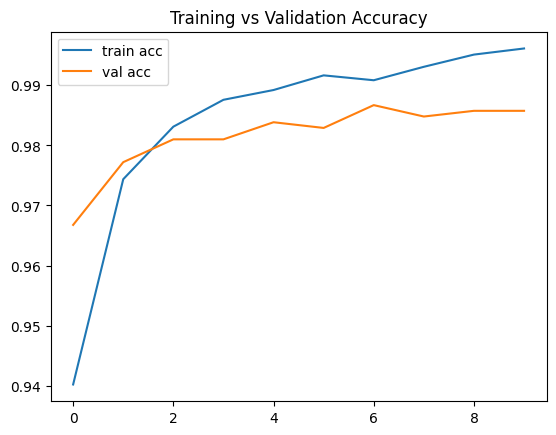

In [26]:
# Plotting training accuracy and validation accuacy for EfficientNet model

plt.plot(eff_history.history['accuracy'], label='train acc')
plt.plot(eff_history.history['val_accuracy'], label='val acc')
plt.legend()
plt.title("Training vs Validation Accuracy")
plt.show()

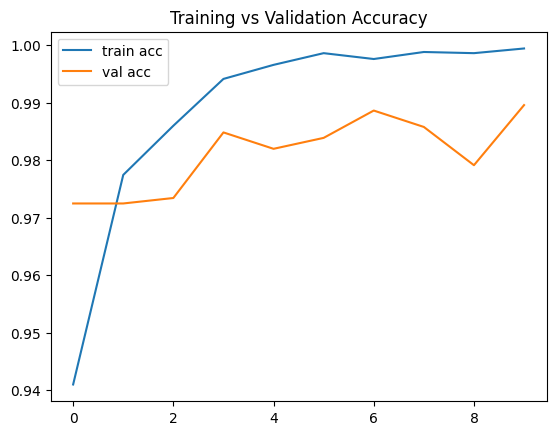

In [27]:
# Plotting training accuracy and validation accuacy for MobileNet model

plt.plot(mob_history.history['accuracy'], label='train acc')
plt.plot(mob_history.history['val_accuracy'], label='val acc')
plt.legend()
plt.title("Training vs Validation Accuracy")
plt.show()

Next, I investegated the image hashes to determine if we had some dupliciates or near dupliciates that might be leading to overfitting.

In [33]:
# Investigate image hashes and determine if duplicates are present

hashes = defaultdict(list)

for path in df_copy['file_path']:
    img = Image.open(path)
    h = imagehash.average_hash(img)
    hashes[str(h)].append(path)

# Show duplicates
duplicates = {h: paths for h, paths in hashes.items() if len(paths) > 1}
print(len(duplicates))

951


In [34]:
# Function to determine image hashes of possible duplicates. 

def get_hashes(df):
    return set(
        str(imagehash.average_hash(Image.open(p))) for p in df['file_path']
    )

train_hashes = get_hashes(train_df)
val_hashes = get_hashes(val_df)
test_hashes = get_hashes(test_df)

print("Train ∩ Val:", len(train_hashes & val_hashes))
print("Train ∩ Test:", len(train_hashes & test_hashes))
print("Val ∩ Test:", len(val_hashes & test_hashes))

Train ∩ Val: 360
Train ∩ Test: 352
Val ∩ Test: 163


Since we determined that there was some duplicates, I wanted to drop those duplicates from our train, validate, and test datasets.

In [35]:
# Generate hashes based on image content
def compute_image_hash(file_path):
    with open(file_path, "rb") as f:
        return hashlib.md5(f.read()).hexdigest()

# Apply to full dataframe
df_copy["image_hash"] = df_copy["file_path"].apply(compute_image_hash)


# Keep only one sample per image_hash
dedup_df = df_copy.drop_duplicates(subset="image_hash", keep="first").copy()

# Check hash-based class distribution
print(dedup_df["binary_label"].value_counts())

# Split with no hash overlap
train_df_hashes, temp_df = train_test_split(
    dedup_df,
    test_size=0.3,
    stratify=dedup_df["binary_label"],
    random_state=42
)


val_df_hashes, test_df_hashes = train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df["binary_label"],
    random_state=42
)

# Confirm no hash overlaps
train_hashes = set(train_df_hashes["image_hash"])
val_hashes = set(val_df_hashes["image_hash"])
test_hashes = set(test_df_hashes["image_hash"])

print("Train ∩ Val:", len(train_hashes & val_hashes))
print("Train ∩ Test:", len(train_hashes & test_hashes))
print("Val ∩ Test:", len(val_hashes & test_hashes))

binary_label
1    4891
0    1706
Name: count, dtype: int64
Train ∩ Val: 0
Train ∩ Test: 0
Val ∩ Test: 0


Now that duplicates have been removed, I created new datasets for both transfer learning models and retrained both models.

In [36]:
# Create duplicate free datasets for EfficientNet model

E_net_train_dataset_hashes = create_dataset(train_df_hashes, model_type="efficientnet")
E_net_val_dataset_hashes = create_dataset(val_df_hashes, model_type="efficientnet", shuffle=False)
E_net_test_dataset_hashes = create_dataset(test_df_hashes, model_type="efficientnet", shuffle=False)

In [37]:
# Retrain EfficientNet model with duplicates removed. 

eff_model_hashes = build_model_efficientnet()

eff_history_hashes = eff_model_hashes.fit(E_net_train_dataset_hashes, validation_data=E_net_val_dataset_hashes, epochs=10)

Epoch 1/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 44s 175ms/step - accuracy: 0.9255 - loss: 0.1925 - val_accuracy: 0.9808 - val_loss: 0.0671
Epoch 2/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.9730 - loss: 0.0743 - val_accuracy: 0.9838 - val_loss: 0.0590
Epoch 3/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - accuracy: 0.9842 - loss: 0.0485 - val_accuracy: 0.9818 - val_loss: 0.0543
Epoch 4/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.9860 - loss: 0.0424 - val_accuracy: 0.9869 - val_loss: 0.0483
Epoch 5/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - accuracy: 0.9903 - loss: 0.0332 - val_accuracy: 0.9859 - val_loss: 0.0499
Epoch 6/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - accuracy: 0.9913 - loss: 0.0298 - val_accuracy: 0.9859 - val_loss: 0.0450
Epoch 7/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.9898 - loss: 0.0311 - val_accuracy: 0.9879 - val_loss: 0.0424
Epoch 8/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.9930 - loss: 0.0247 - val_ac

In [38]:
# Evaluate testing accuracy 

test_loss, test_acc = eff_model_hashes.evaluate(E_net_test_dataset_hashes)
print(f"Test Accuracy: {test_acc:.4f}")

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.9920 - loss: 0.0238
Test Accuracy: 0.9899


In [39]:
# Evaluate confusion matrix and classification report

evaluate_model(eff_model_hashes, E_net_test_dataset_hashes, model_name="EfficientNet")

=== Evaluation for EfficientNet ===
Confusion Matrix:
[[250   6]
 [  4 730]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9843    0.9766    0.9804       256
           1     0.9918    0.9946    0.9932       734

    accuracy                         0.9899       990
   macro avg     0.9880    0.9856    0.9868       990
weighted avg     0.9899    0.9899    0.9899       990



In [40]:
# Create duplicate free datasets for MobileNet model

M_net_train_dataset_hashes = create_dataset(train_df_hashes, model_type="mobilenet")
M_net_val_dataset_hashes = create_dataset(val_df_hashes, model_type="mobilenet", shuffle=False)
M_net_test_dataset_hashes = create_dataset(test_df_hashes, model_type="mobilenet", shuffle=False)

In [41]:
# Retrain MobileNet model with duplicates removed. 

mob_model_hashes = build_model_mobilenet()

mob_history_hashes = mob_model_hashes.fit(M_net_train_dataset_hashes, validation_data=M_net_val_dataset_hashes,epochs=10)

Epoch 1/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 21s 98ms/step - accuracy: 0.9035 - loss: 0.2534 - val_accuracy: 0.9747 - val_loss: 0.0794
Epoch 2/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - accuracy: 0.9789 - loss: 0.0601 - val_accuracy: 0.9778 - val_loss: 0.0600
Epoch 3/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - accuracy: 0.9890 - loss: 0.0386 - val_accuracy: 0.9798 - val_loss: 0.0568
Epoch 4/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.9921 - loss: 0.0255 - val_accuracy: 0.9798 - val_loss: 0.0513
Epoch 5/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.9942 - loss: 0.0198 - val_accuracy: 0.9798 - val_loss: 0.0511
Epoch 6/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.9953 - loss: 0.0156 - val_accuracy: 0.9808 - val_loss: 0.0552
Epoch 7/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - accuracy: 0.9949 - loss: 0.0155 - val_accuracy: 0.9818 - val_loss: 0.0523
Epoch 8/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.9961 - loss: 0.0140 - val_acc

In [42]:
# Evaluate testing accuracy 

test_loss, test_acc = mob_model_hashes.evaluate(M_net_test_dataset_hashes)
print(f"Test Accuracy: {test_acc:.4f}")

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.9865 - loss: 0.0534
Test Accuracy: 0.9869


In [43]:
# Evaluate confusion matrix and classification report

evaluate_model(mob_model_hashes, M_net_test_dataset_hashes, model_name="MobileNet")

=== Evaluation for MobileNet ===
Confusion Matrix:
[[245  11]
 [  2 732]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9919    0.9570    0.9742       256
           1     0.9852    0.9973    0.9912       734

    accuracy                         0.9869       990
   macro avg     0.9885    0.9772    0.9827       990
weighted avg     0.9869    0.9869    0.9868       990



Both models performed very well on the testing sets. However, I still suspect that there might be some overfitting or data leakage. The next step was to add some augmentation to the training sets and retest performance.

### Data Augmentation

In [71]:
# Convert binary labels to strings to avoid downstream issues

train_df_hashes["binary_label"] = train_df_hashes["binary_label"].astype(str)
val_df_hashes["binary_label"] = val_df_hashes["binary_label"].astype(str)
test_df_hashes["binary_label"] = test_df_hashes["binary_label"].astype(str)

In [140]:
from tensorflow.keras.applications.efficientnet import preprocess_input as effnet_preprocess
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess

# Create augmentation for the training data used in EfficientNet model. 

train_datagen_eff = ImageDataGenerator(
    preprocessing_function=effnet_preprocess,
    rotation_range=15,                  # slight rotation
    width_shift_range=0.05,             # small horizontal shift
    height_shift_range=0.05,            # small vertical shift
    zoom_range=0.1,                     # slight zoom in/out
    shear_range=0.05,                   # minor shearing
    brightness_range=[0.8, 1.2],        # simulate MRI brightness variation
    horizontal_flip=True,               
    fill_mode='nearest'                 # fill in missing pixels after transform
)

# Create augmentation for the training data used in MobileNet model. 

train_datagen_mob = ImageDataGenerator(
    preprocessing_function=mobilenet_preprocess,
    rotation_range=15,                  # slight rotation
    width_shift_range=0.05,             # small horizontal shift
    height_shift_range=0.05,            # small vertical shift
    zoom_range=0.1,                     # slight zoom in/out
    shear_range=0.05,                   # minor shearing
    brightness_range=[0.8, 1.2],        # simulate MRI brightness variation
    horizontal_flip=True,              
    fill_mode='nearest'                 # fill in missing pixels after transform
)

val_test_datagen_mob = ImageDataGenerator(rescale=1./255)

val_test_datagen_eff = ImageDataGenerator(rescale=1./255)

In [90]:
# Create new datasets with augmented images used with the MobileNet model. 

train_generator_mob = train_datagen_mob.flow_from_dataframe(
    dataframe=train_df_hashes,
    x_col="file_path",
    y_col="binary_label",
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

val_generator_mob = val_test_datagen_mob.flow_from_dataframe(
    dataframe=val_df_hashes,
    x_col="file_path",
    y_col="binary_label",
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

test_generator_mob = val_test_datagen_mob.flow_from_dataframe(
    dataframe=test_df_hashes,
    x_col="file_path",
    y_col="binary_label",
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Found 4617 validated image filenames belonging to 2 classes.
Found 990 validated image filenames belonging to 2 classes.
Found 990 validated image filenames belonging to 2 classes.


In [92]:
# Create new datasets with augmented images used with the EfficientNet model. 

train_generator_eff = train_datagen_eff.flow_from_dataframe(
    dataframe=train_df_hashes,
    x_col="file_path",
    y_col="binary_label",
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

val_generator_eff = val_test_datagen_eff.flow_from_dataframe(
    dataframe=val_df_hashes,
    x_col="file_path",
    y_col="binary_label",
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

test_generator_eff = val_test_datagen_eff.flow_from_dataframe(
    dataframe=test_df_hashes,
    x_col="file_path",
    y_col="binary_label",
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Found 4617 validated image filenames belonging to 2 classes.
Found 990 validated image filenames belonging to 2 classes.
Found 990 validated image filenames belonging to 2 classes.


In [94]:
from tensorflow.keras.utils import load_img, img_to_array

In [98]:
# Create and train EfficientNet model with augmented data

eff_model_augmented = build_model_efficientnet()

eff_history_augmented = eff_model_augmented.fit(train_generator_eff, validation_data=val_generator_eff, class_weight=class_weights, epochs=10)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 97s 541ms/step - accuracy: 0.9140 - loss: 0.2224 - val_accuracy: 0.7414 - val_loss: 0.6072
Epoch 2/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 65s 449ms/step - accuracy: 0.9665 - loss: 0.0994 - val_accuracy: 0.7414 - val_loss: 0.6894
Epoch 3/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 64s 442ms/step - accuracy: 0.9805 - loss: 0.0648 - val_accuracy: 0.7414 - val_loss: 0.7395
Epoch 4/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 64s 438ms/step - accuracy: 0.9832 - loss: 0.0567 - val_accuracy: 0.7414 - val_loss: 0.7146
Epoch 5/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 63s 436ms/step - accuracy: 0.9833 - loss: 0.0432 - val_accuracy: 0.7414 - val_loss: 0.8901
Epoch 6/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 63s 437ms/step - accuracy: 0.9822 - loss: 0.0529 - val_accuracy: 0.7414 - val_loss: 0.7499
Epoch 7/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 63s 436ms/step - accuracy: 0.9872 - loss: 0.0342 - val_accuracy: 0.7414 - val_loss: 0.6158
Epoch 8/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 63s 432ms/step - accuracy: 0.9868 - loss: 0

In [99]:
# Create and train MobileNet model with augmented data

mob_model_augmented = build_model_mobilenet()

mob_history_augmented = mob_model_augmented.fit(train_generator_mob, validation_data=val_generator_mob, class_weight=class_weights, epochs=10)

Epoch 1/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 77s 475ms/step - accuracy: 0.9142 - loss: 0.2177 - val_accuracy: 0.9556 - val_loss: 0.1270
Epoch 2/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 63s 433ms/step - accuracy: 0.9811 - loss: 0.0647 - val_accuracy: 0.9596 - val_loss: 0.1170
Epoch 3/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 62s 426ms/step - accuracy: 0.9737 - loss: 0.0821 - val_accuracy: 0.9384 - val_loss: 0.1779
Epoch 4/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 62s 430ms/step - accuracy: 0.9788 - loss: 0.0638 - val_accuracy: 0.9616 - val_loss: 0.1064
Epoch 5/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 63s 433ms/step - accuracy: 0.9836 - loss: 0.0469 - val_accuracy: 0.9737 - val_loss: 0.0772
Epoch 6/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 63s 431ms/step - accuracy: 0.9883 - loss: 0.0406 - val_accuracy: 0.9606 - val_loss: 0.1035
Epoch 7/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 62s 429ms/step - accuracy: 0.9908 - loss: 0.0300 - val_accuracy: 0.9596 - val_loss: 0.1120
Epoch 8/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 62s 430ms/step - accuracy: 0.9843 - loss: 0

In [125]:
# Function to create confusion matrix and classification report for augmented models

def evaluate_model_on_generator(model, generator, model_name="Model"):
    # Get ground truth labels
    y_true = generator.classes

    # Predict probabilities
    y_prob = model.predict(generator, verbose=1)

    # Convert probabilities to class labels (binary threshold at 0.5)
    y_pred = (y_prob > 0.3).astype(int).flatten()

    # Report
    print(f"\n=== Evaluation for {model_name} ===")
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, digits=4))

In [126]:
# Confusion matrix and Classification report for MobileNet model.

evaluate_model_on_generator(mob_model_augmented, test_generator_mob, model_name="MobileNet")

31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step

=== Evaluation for MobileNet ===
Confusion Matrix:
[[197  59]
 [  2 732]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9899    0.7695    0.8659       256
           1     0.9254    0.9973    0.9600       734

    accuracy                         0.9384       990
   macro avg     0.9577    0.8834    0.9130       990
weighted avg     0.9421    0.9384    0.9357       990



In [127]:
# Confusion matrix and Classification report for EfficientNet model.

evaluate_model_on_generator(eff_model_augmented, test_generator_eff, model_name="EfficientNet")

31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step

=== Evaluation for EfficientNet ===
Confusion Matrix:
[[  0 256]
 [  0 734]]

Classification Report:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       256
           1     0.7414    1.0000    0.8515       734

    accuracy                         0.7414       990
   macro avg     0.3707    0.5000    0.4258       990
weighted avg     0.5497    0.7414    0.6313       990



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


As we can see, the MobileNet model still preformed very well. However, there appears to be a deeper issue with the EfficientNet model.  

Lets investegate that model.  

I started by unfreezing and tuning some top layers of the base model to see if there was an improvement.

In [ ]:
from tensorflow.keras.applications import EfficientNetB0

# Create base EfficientNet model 

base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(224, 224, 3), pooling='avg')
base_model.trainable = False  # Initially freeze

In [144]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Freeze base model

base_model = EfficientNetB0(include_top=False, input_shape=(224, 224, 3), weights='imagenet', pooling='avg')
base_model.trainable = False

inputs = Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)  # Output shape: [batch_size, 1280]
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(1, activation='sigmoid')(x)  # Binary classification output

eff_model_augmented = Model(inputs, outputs)

# Compile model with higher LR
eff_model_augmented.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',  # Your custom focal loss function
    metrics=['accuracy']
)

# Callbacks
callbacks = [
    EarlyStopping(patience=3, restore_best_weights=True),
    ReduceLROnPlateau(patience=2, factor=0.5, verbose=1),
    ModelCheckpoint('model_phase1.h5', save_best_only=True)
]

# Train only top layers
history_phase1 = eff_model_augmented.fit(
    train_generator_eff,
    validation_data=val_generator_eff,
    epochs=10,
    callbacks=callbacks
)

# Fine-tune base model
-
# Unfreeze the last 100 layers
N = 100
for layer in base_model.layers[-N:]:
    layer.trainable = True

# Recompile with lower learning rate
eff_model_augmented.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Callbacks (use a new checkpoint filename)
callbacks_fine = [
    EarlyStopping(patience=3, restore_best_weights=True),
    ReduceLROnPlateau(patience=2, factor=0.5, verbose=1),
    ModelCheckpoint('model_finetuned.h5', save_best_only=True)
]

# Fine-tune entire model
history_phase2 = eff_model_augmented.fit(
    train_generator_eff,
    validation_data=val_generator_eff,
    epochs=10,
    class_weight=class_weights,
    callbacks=callbacks_fine
)

Epoch 1/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step - accuracy: 0.8060 - loss: 0.3935

145/145 ━━━━━━━━━━━━━━━━━━━━ 96s 541ms/step - accuracy: 0.8067 - loss: 0.3926 - val_accuracy: 0.7414 - val_loss: 0.5821 - learning_rate: 1.0000e-04
Epoch 2/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step - accuracy: 0.9609 - loss: 0.1293

145/145 ━━━━━━━━━━━━━━━━━━━━ 64s 440ms/step - accuracy: 0.9609 - loss: 0.1292 - val_accuracy: 0.7414 - val_loss: 0.5749 - learning_rate: 1.0000e-04
Epoch 3/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 63s 436ms/step - accuracy: 0.9676 - loss: 0.1103 - val_accuracy: 0.7414 - val_loss: 0.5876 - learning_rate: 1.0000e-04
Epoch 4/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step - accuracy: 0.9761 - loss: 0.0740
Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
145/145 ━━━━━━━━━━━━━━━━━━━━ 63s 432ms/step - accuracy: 0.9761 - loss: 0.0741 - val_accuracy: 0.7414 - val_loss: 0.5913 - learning_rate: 1.0000e-04
Epoch 5/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 63s 433ms/step - accuracy: 0.9678 - loss: 0.0924 - val_accuracy: 0.7414 - val_loss: 0.5912 - learning_rate: 5.0000e-05
Epoch 1/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 515ms/step - accuracy: 0.8505 - loss: 0.3308

145/145 ━━━━━━━━━━━━━━━━━━━━ 124s 597ms/step - accuracy: 0.8509 - loss: 0.3304 - val_accuracy: 0.7414 - val_loss: 0.6522 - learning_rate: 1.0000e-05
Epoch 2/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 63s 437ms/step - accuracy: 0.9631 - loss: 0.1535 - val_accuracy: 0.7414 - val_loss: 0.6638 - learning_rate: 1.0000e-05
Epoch 3/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step - accuracy: 0.9699 - loss: 0.1116
Epoch 3: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
145/145 ━━━━━━━━━━━━━━━━━━━━ 63s 437ms/step - accuracy: 0.9699 - loss: 0.1116 - val_accuracy: 0.7414 - val_loss: 0.6751 - learning_rate: 1.0000e-05
Epoch 4/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 63s 435ms/step - accuracy: 0.9755 - loss: 0.0835 - val_accuracy: 0.7414 - val_loss: 0.6801 - learning_rate: 5.0000e-06


In [145]:
# Confusion matrix and classification report for base model tuning. 

evaluate_model_on_generator(eff_model_augmented, test_generator_eff, model_name="EfficientNet")

31/31 ━━━━━━━━━━━━━━━━━━━━ 13s 241ms/step

=== Evaluation for EfficientNet ===
Confusion Matrix:
[[  0 256]
 [  0 734]]

Classification Report:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       256
           1     0.7414    1.0000    0.8515       734

    accuracy                         0.7414       990
   macro avg     0.3707    0.5000    0.4258       990
weighted avg     0.5497    0.7414    0.6313       990



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


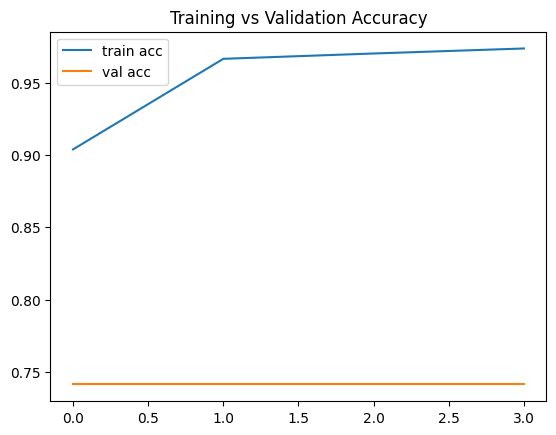

In [146]:
# Plot of training and validation accuracy

plt.plot(history_phase2.history['accuracy'], label='train acc')
plt.plot(history_phase2.history['val_accuracy'], label='val acc')
plt.legend()
plt.title("Training vs Validation Accuracy")
plt.show()

The model is still prediciting all images to be tumors. So, I started by confirming output shape and target label consistency

In [148]:
# Checking output shape and target labels. 

x_batch, y_batch = next(train_generator_eff)
print("Image batch shape:", x_batch.shape)  # (32, 224, 224, 3)
print("Label batch shape:", y_batch.shape)  # (32,)
print("Unique labels:", np.unique(y_batch))  # should be [0. 1.]

Image batch shape: (32, 224, 224, 3)
Label batch shape: (32,)
Unique labels: [0. 1.]


Next I wanted to check that labels and predictions are aligned

In [129]:
# 10 model predictions

preds = eff_model_augmented.predict(test_generator_eff)
print("Sample predictions (raw):", preds[:10].flatten())

31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step
Sample predictions (raw): [0.59777194 0.5974626  0.5966644  0.5973028  0.597405   0.5966482
 0.59627444 0.59684926 0.5968112  0.5989893 ]


In [130]:
# Converting predictions to binary

preds_binary = (preds > 0.5).astype(int)
print("Sample predictions (binary):", preds_binary[:10].flatten())

Sample predictions (binary): [1 1 1 1 1 1 1 1 1 1]


To gather some more information I plotted the training and validation loss for both phases. 

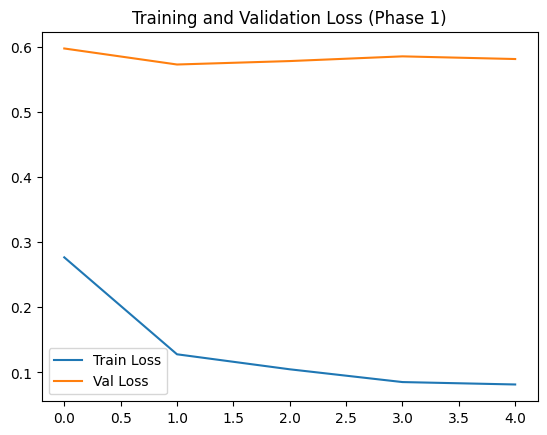

In [131]:
#  Plot of training and validation loss for phase 1

plt.plot(history_phase1.history['loss'], label='Train Loss')
plt.plot(history_phase1.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Training and Validation Loss (Phase 1)")
plt.show()

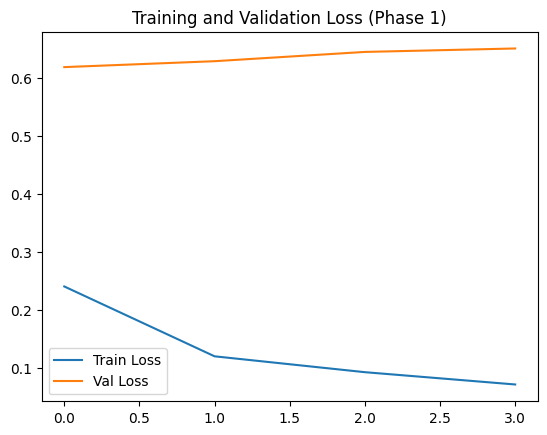

In [132]:
#  Plot of training and validation loss for phase 2

plt.plot(history_phase2.history['loss'], label='Train Loss')
plt.plot(history_phase2.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Training and Validation Loss (Phase 1)")
plt.show()

Next, I verified that the data was split correctly and all datasets had both tumor and non-tumor images.

In [134]:
from collections import Counter

# print binary label counts of all datasets

print(Counter(train_df_hashes['binary_label']))
print(Counter(val_df_hashes['binary_label']))
print(Counter(test_df_hashes['binary_label']))

Counter({'1': 3423, '0': 1194})
Counter({'1': 734, '0': 256})
Counter({'1': 734, '0': 256})


In [135]:
# Verify only the top 100 layers were unfrozen.

trainable_layers = [l.name for l in base_model.layers if l.trainable]
print(f"Trainable layers in base model: {len(trainable_layers)}")

Trainable layers in base model: 100


there does not appear to be a standout root cause for our model predicting all tumors.  

Next, I compared this same data with the MobileNet model.  

I started by confirming generator outputs are correct

In [136]:
# Checking output shape and target labels. 

batch_x, batch_y = next(train_generator_mob)  
print("Images shape:", batch_x.shape)
print("Labels shape:", batch_y.shape)
print("Unique labels in batch:", np.unique(batch_y))

Images shape: (32, 224, 224, 3)
Labels shape: (32,)
Unique labels in batch: [0. 1.]


In [137]:
# 10 model predictions

preds = mob_model_augmented.predict(test_generator_mob)
print("Sample predictions (raw):", preds[:10].flatten())

31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step
Sample predictions (raw): [9.8805702e-01 7.2715119e-03 9.9998486e-01 1.3083010e-03 9.9947351e-01
 9.9358749e-01 9.9982953e-01 4.7094113e-04 7.4123544e-01 3.9643236e-03]


In [138]:
# Converting predictions to binary

preds_binary = (preds > 0.5).astype(int)
print("Sample predictions (binary):", preds_binary[:10].flatten())

Sample predictions (binary): [1 0 1 0 1 1 1 0 1 0]


In [139]:
# Create confusion matrix and classification report of MobilNet model for comparison. 

# Get true labels
y_true = test_generator_mob.classes  

# Get binary predictions
y_pred = (mob_model_augmented.predict(test_generator_mob) > 0.5).astype(int).flatten()

print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

print("\nClassification Report:")
print(classification_report(y_true, y_pred))

31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step
Confusion Matrix:
[[211  45]
 [  3 731]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.82      0.90       256
           1       0.94      1.00      0.97       734

    accuracy                           0.95       990
   macro avg       0.96      0.91      0.93       990
weighted avg       0.95      0.95      0.95       990



Key Issues Observed:  

* Severe class imbalance in predictions (recall of 1.0 for one class, 0.0 for the other).

* Confusion matrix often looked like:
[0 256]
[0 734]

* Preprocessing was confirmed correct (preprocessing_function=effnet_preprocess), so input scaling wasn't the root cause.

I also attempted:

* Freezing and unfreezing layers

* Adjusting the number of trainable layers

* Modifying learning rates and optimizer settings

* Rebuilding the model from scratch using Functional API

* Balancing classes using class_weight


Final Conclusion:  

Despite proper architecture and input preprocessing, EfficientNetB0 consistently overfit or failed to converge meaningfully on this specific dataset.  

The problem may stem from:

Over-complexity or mismatch between EfficientNet's inductive bias and the dataset's size/content.

The model potentially memorizing features without learning useful decision boundaries for both classes.  

One troubleshooting step that I did not perform, but would like to in the future, is visualizing with Grad_CAM. This would help me understand what the model is looking at when making predictions. 

### Save Final Model

Due to time constraints, I was unable to investigate EfficientNet model further.  

I mad the decision to go with MobileNetV2 model. It has a lighter architecture better suited for this binary classification task. Also after proper data augmentation and fine-tuning, MobileNetV2 produced balanced, high-quality predictions with 95%+ accuracy, strong F1-scores, and stable convergence.

In [ ]:
# Save final model

mob_model_augmented.save("mobilenet_mri_classifier.keras")